In [1]:
# import libraries 
import numpy as np
import pandas as pd
import re
import networkx as nx
from collections import defaultdict
import warnings
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from collections import defaultdict

In [2]:
# import data
nodes = pd.read_csv(r'C:\Users\ludom\OneDrive\Desktop\ADM\HOMEWORKS\HW_5\data\nodes.csv')
edges = pd.read_csv(r'C:\Users\ludom\OneDrive\Desktop\ADM\HOMEWORKS\HW_5\data\edges.csv\edges.csv')
hero_net = pd.read_csv(r'C:\Users\ludom\OneDrive\Desktop\ADM\HOMEWORKS\HW_5\data\hero-network.csv\hero-network.csv')

# 1) DATA 

### Data Preprocessing
1. Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency exists for the following reasons:
- Some heroes' names in 'hero-netowrk.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'.
- Some heroes' names in 'hero-netowrk.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'.
- The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'.

2. Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.

In [3]:
# We define a function that removes excess spaces and the character '/' at the end of the heroes' name.

def remove_extra_spaces_and_slashes(string):
    # Remove extra spaces at the end of the string
    string = re.sub(r'\s+$', '', string)

    # Remove an extra forward slash at the end of the string, if present
    string = re.sub(r'\/+$', '', string)

    return string

In [4]:
# remove extra spaces and '/' at the end of the heroes' names
# apply the function above to the two columns 
hero_net['hero1'] = hero_net['hero1'].apply(lambda row: remove_extra_spaces_and_slashes(row))

hero_net['hero2'] = hero_net['hero2'].apply(lambda row: remove_extra_spaces_and_slashes(row))

In [5]:
# We replace the wrong name with the correct name in the already cleaned columns.
hero_net['hero1'] = hero_net['hero1'].replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER')
hero_net['hero2'] = hero_net['hero2'].replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER')

In [6]:
# indices of the rows that have the same hero name in both columns
idx = hero_net[hero_net['hero1'] == hero_net['hero2']].index
len(idx)

2232

In [7]:
# before removing those rows
hero_net.shape

(574467, 2)

In [8]:
# remove those rows that have the same hero name in both columns
hero_net = hero_net.drop(idx)

In [9]:
# after removing those rows
hero_net.shape

(572235, 2)

We have removed 2232 observations.

### Graphs setup
For this homework, we are going to build two different graphs:

1. First graph: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

2. Second graph: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

#### 1st Graph

In [10]:
# function that creates a graph of type 1

def graph1(dataset):
    # Initialize a dictionary to store the counts of each superhero pair
    hero_pair_counts = defaultdict(int)

    # Iterate over the rows in the dataset
    for index, row in dataset.iterrows():
      # Get the values of the hero1 and hero2 columns
        hero1 = row['hero1']
        hero2 = row['hero2']

        pair = tuple(sorted([hero1, hero2]))
        hero_pair_counts[pair] += 1
    
    # initialize the graph
    G_hero_net = nx.Graph()
    
    # loop over the dataset and add the nodes & edges with the corresponding weight
    for k,v in hero_pair_counts.items():
        G_hero_net.add_edge(k[0],k[1], weight= 1/v)
    
    return G_hero_net

In [11]:
G1 = graph1(hero_net)

In [12]:
nx.info(G1)

'Graph with 6421 nodes and 167100 edges'

#### 2nd graph

In [13]:
# function that creates a graph of type 2

def graph2(df_edges,df_nodes):
    # initialize the graph
    G2 = nx.MultiGraph()
    # add all nodes to the graph from the dataset
    for i in range(df_nodes.shape[0]):
        G2.add_node(df_nodes['node'].loc[i])
        G2.nodes()[df_nodes['node'].loc[i]]['type'] = df_nodes['type'].loc[i]
        
    # add all edges to the graph from the dataset
    df_edges.apply(lambda row: G2.add_edge(row['hero'], row['comic']), axis=1)
    
    return G2

In [14]:
G2 = graph2(edges,nodes)

In [15]:
nx.info(G2)

'MultiGraph with 19091 nodes and 96104 edges'

In [16]:
G2.nodes['SPIDER-MAN/PETER PARKER']["type"]="hero"

# 2/3) Backend and FRONTEND Implementation

We chose to write down the functionalities and immediately after the respective visualizations.

Step 1: Define the function that outputs the top_N_heros we want to consider.

In [17]:
# Top N heroes
def top_N_heroes(dataset, N = None):
    if N == None:
        N = len(dataset)
    
    # group the dataset by 'hero' and count the number of comics where each hero has appeared
    df_grouped = dataset.groupby('hero').agg(count = ('comic','count')).reset_index()
    df_grouped = df_grouped.sort_values(by='count', ascending=False)
    
    # take the top N heroes based on number of comics they've appeared in
    top_N = df_grouped[:N]
    
    # names of top N heroes
    names_topN = top_N['hero']
    
    return list(names_topN)

In [18]:
top_N_heroes(edges,N=5)

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK']

Step 2: Define the function that outputs the subgraph whose nodes are the top_N_heroes considered. 

In [19]:
# Subgraph with some specific N
def subgraph(graph,n=None):

    # create an empty graph
    G_small = nx.Graph()

    # I choose the most important N heros based on the degree centrality measure:
    
    heros=top_N_heroes(edges,N=n)

    # compute the subgraph based on the type of graph
    if graph==G1:

        if n==None:
            return G1
        else:

            for i in G1.nodes():
                if i in heros:
                    G_small.add_node(i)

            for edge in G1.edges():
                if (edge[0] in heros) and (edge[1] in heros):
                    w = list(G1.edges()[edge].values())[0]
                    G_small.add_edge(edge[0],edge[1], weight = w)
    
    elif graph==G2:

        if n==None:
            return G2
        else: 
                
            comics = set(list(edges[edges['hero'].isin(heros)]['comic']))

            for i in G2.nodes():
                if (i in heros) or (i in comics):
                    G_small.add_node(i)
                    # add the original label to the node
                    G_small.nodes()[i]['type'] = list(G2.nodes()[i].values())

            for edge in G2.edges():
                if ((edge[0] in heros) and (edge[1] in comics)) or ((edge[1] in heros) and (edge[0] in comics)):
                    G_small.add_edge(edge[0],edge[1])
    
    else: 
        raise ValueError ("The graph you chose is not valid")
    
    return G_small

### Functionality 1 - extract the graph's features
Input:
- The graph data
- The graph type (ex., number 1 or number 2)
- N: denoting the top N heroes that their data should be considered

Output:
- The number of nodes in the network (if type 2, report for both node types)
- The number of collaborations of each superhero with the others (only if type 1)
- The number of heroes that have appeared in each comic (only if type 2)
- The network's density
- The network's degree distribution
- The average degree of the network
- The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the Network is sparse or dense


Note: For this case, it makes sense to differentiate operations between the two graphs: for example, when computing hubs for the second graph, we likely care only about comics.

Let's make a different function for each oune of the output we need

In [20]:
# 1) Number of nodes for type 1 and for type 2
def number_nodes(graph,g_type,N=None):
    # g_type = 1 --> number of nodes
    if g_type == 1:
        if N==None:
            return (f"The graph has {graph.number_of_nodes()} nodes.")
        else:
            g1=subgraph(graph,N)
            return (f"The graph has {g1.number_of_nodes()} nodes.")
        
    # g_type = 2 --> number of nodes of type hero & number of nodes of type comic
    else: 
        if N==None:
            labels = nx.get_node_attributes(graph, 'type')
            num_hero = list(labels.values()).count('hero')
            num_comic = list(labels.values()).count('comic')
            return (f"The graph has {num_hero} nodes of type 'hero' and {num_comic} nodes of type 'comic'.")
        else:
            g=subgraph(graph,N)
            sub_comic=0
            for i in g.nodes():
                if g.nodes()[i]['type']==['comic']:
                    sub_comic+=1
            tot=g.number_of_nodes()
            sub_heroes=tot-sub_comic
            return (f"The graph has {sub_heroes} nodes of type 'hero' and {sub_comic} nodes of type 'comic'.")


In [21]:
# 2) Number of collaborations of each superhero with the others (only G1)
def number_connections(graph,g_type):
    if g_type==1:
    # dictionary where we'll store the comics' names and the number of connections
        num_connect_per_hero = {}
        
        # loop over all nodes (heroes) and sum the reciprocal of the edge weights (weight = 1 / number of edges)
        for i in graph.nodes():
            num_connections = 0
            for k1,v1 in graph[i].items():
                for k2,v2 in v1.items():
                    num_connections += 1/v2
            num_connect_per_hero[i] = int(num_connections)
    
        return num_connect_per_hero
    
    else:
        raise ValueError("The graph you chose is not valid")

In [22]:
# 3) Number of heroes per comic (only for G2)
def heros_per_comic(graph, graph_type, N=None):

    if graph_type == 2:

        labels = nx.get_node_attributes(graph, 'type')

        comic_d = {k: v for k, v in labels.items() if v != 'hero'}
        
        comic_heros_d = {}

        for i in comic_d:
            comic_heros_d[i] = graph.degree(i)
            
        # Sort the dictionary by its values
        final_d = dict(sorted(comic_heros_d.items(), key=lambda item: item[1], reverse = True))
        
        # Returns the first N elements of the dictionary
        return dict(islice(final_d.items(), N))
    
    else:
        raise ValueError("The graph you chose is not valid")

In [23]:
# 4) Network's density
def density(graph):
    return round(nx.density(graph),5)

In [24]:
# 5) Network's degree
def distribution_degree(graph):
    degrees = [graph.degree(n) for n in graph.nodes()]
    d = defaultdict(int)

    for elem in degrees:
        d[elem] += 1
    
    D=sorted(d.items(), key=lambda x: x[0])
    return dict(D)

In [25]:
# 6) Network's average degree
def average_degree(graph):
    return sum([d for (n, d) in nx.degree(graph)]) / graph.number_of_nodes()

In [26]:
# 7) Network's hubs
def network_hubs(graph, g_type):
    if g_type == 1:
        # dictionary key = node, value = degree of node (number of edges)
        degree_distr = dict(nx.degree(graph))
        
        # quantile 95%
        q95 = np.percentile(list(degree_distr.values()), 95)
        
        # loop over all elements of the dictionary above
        hubs = {}
        for k,v in degree_distr.items():
            # if the node's degree > 95th quantile, keep it
            if v >= q95:
                hubs[k] = v
    else:
        # take only the 'comic' nodes
        list_values = []
        for i in G2.nodes():
            if list(G2.nodes()[i].values()) == ['comic']:
                list_values.append(len(G2[i]))

        # quantile 95%
        q95 = np.percentile(list_values, 95)

        hubs = {}
        for j in G2.nodes():
            if list(G2.nodes()[j].values()) == ['comic']:
                if len(G2[j]) >= q95:
                    hubs[j] = len(G2[j])

    return hubs

In [27]:
# 8) Network dense or sparse
def dense_sparse(graph):
    if nx.density(graph)>0.5:
        return "Dense"
    else:
        return "Sparse"   

Now let's write the first functionality

In [28]:
# FUNCTIONALITY 1 --> EXTRACT G-FEATURES

def Extract_G_Features(graph, g_type, N=None):
    if (g_type != 1) & (g_type != 2):
        return 'Wrong Graph Type'
    else:

        # extract the names of the top N heroes
        names_heroes = top_N_heroes(edges,N=N)

        # do the subgraph if N is specified
        graph_new=subgraph(graph,N)

        # number of nodes (depending on the g_type)
        num_nodes=number_nodes(graph,g_type,N)

        # graph density
        g_density=density(graph_new)

        # graph degree
        g_degree= distribution_degree(graph_new)

        # graph avg_degree
        g_avg_degree=average_degree(graph_new)

        # hubs
        hubs=network_hubs(graph_new, g_type)

        # dense or sparse
        den_spar=dense_sparse(graph_new)

        if g_type==1:
            
            # number of collab
            num_collab=number_connections(graph_new,g_type)

            return num_nodes, num_collab, g_density, g_degree, g_avg_degree, hubs, den_spar

        else: 
            
            # number of heroes per comic
            h_per_c=heros_per_comic(graph_new, g_type, N)

            return num_nodes, h_per_c, g_density, g_degree, g_avg_degree, hubs, den_spar

In [30]:
test1=Extract_G_Features(G1, 1,10)
test1

('The graph has 10 nodes.',
 {'IRON MAN/TONY STARK': 1481,
  'HULK/DR. ROBERT BRUC': 796,
  'SPIDER-MAN/PETER PARKER': 981,
  'CAPTAIN AMERICA': 1807,
  'WOLVERINE/LOGAN': 520,
  'MR. FANTASTIC/REED R': 2808,
  'THING/BENJAMIN J. GR': 2844,
  'INVISIBLE WOMAN/SUE': 2662,
  'THOR/DR. DONALD BLAK': 1415,
  'HUMAN TORCH/JOHNNY S': 2854},
 1.0,
 {9: 10},
 9.0,
 {'IRON MAN/TONY STARK': 9,
  'HULK/DR. ROBERT BRUC': 9,
  'SPIDER-MAN/PETER PARKER': 9,
  'CAPTAIN AMERICA': 9,
  'WOLVERINE/LOGAN': 9,
  'MR. FANTASTIC/REED R': 9,
  'THING/BENJAMIN J. GR': 9,
  'INVISIBLE WOMAN/SUE': 9,
  'THOR/DR. DONALD BLAK': 9,
  'HUMAN TORCH/JOHNNY S': 9},
 'Dense')

In [ ]:
# Since this output is too long, as a matter of order we do not print it below but put the attached output as a txt file (output_func1_G2) in the github folder.
test_two=Extract_G_Features(G2,2,3)
test_two

### Visualization 1

- A table containing the following general information about the graph:
    - Number of nodes in the network
    - Density of the network
    - Average degree of the network
    - Whether the network is sparse or dense
    - A table that lists the network's hubs
    

- A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

- A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

- A plot depicting the degree distribution of the network

V1: A table containing the following general information about the graph:

- Number of nodes in the network
- Density of the network
- Average degree of the network
- Whether the network is sparse or dense

In [31]:
def V1(graph,N=None):
    
    g_new=subgraph(graph,N)

    dataframe = pd.DataFrame([{'number_of_nodes' : g_new.number_of_nodes(), "density" : nx.density(g_new),
                  "average_degree" : average_degree(g_new), 'sparse_dense' : dense_sparse(g_new)}])
    return dataframe.set_index(['number_of_nodes', "density", "average_degree", 'sparse_dense']) 

In [32]:
# Test 1
Viz_1_1=V1(G1,600)
Viz_1_1

,,,
number_of_nodes,density,average_degree,sparse_dense
591,0.22393,132.118443,Sparse


In [33]:
# Test 2
Viz_1_2=V1(G2,800)
Viz_1_2

,,,
number_of_nodes,density,average_degree,sparse_dense
13060,0.00085,11.101378,Sparse


V2: A table that lists the network's hubs

In [34]:
def V2(graph,g_type,N=None):
    
    g_new=subgraph(graph,N)

    df=pd.DataFrame(network_hubs(g_new,g_type).items(), columns=['hero/comic', 'hubs'])

    return df.set_index(['hero/comic', 'hubs'])

In [35]:
Viz_2_1=V2(G1,1)
Viz_2_1.head()

,
hero/comic,hubs
BLACK PANTHER/T'CHAL,711
IRON MAN/TONY STARK,1521
IRON MAN IV/JAMES R.,465
"ROM, SPACEKNIGHT",241
BLOB/FRED J. DUKES,423


In [36]:
Viz_2_2=V2(G2,2)
Viz_2_2.head()

,
hero/comic,hubs
A '00,23
A 100,20
A 105,21
A 10,35
A 116,19


V3: A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

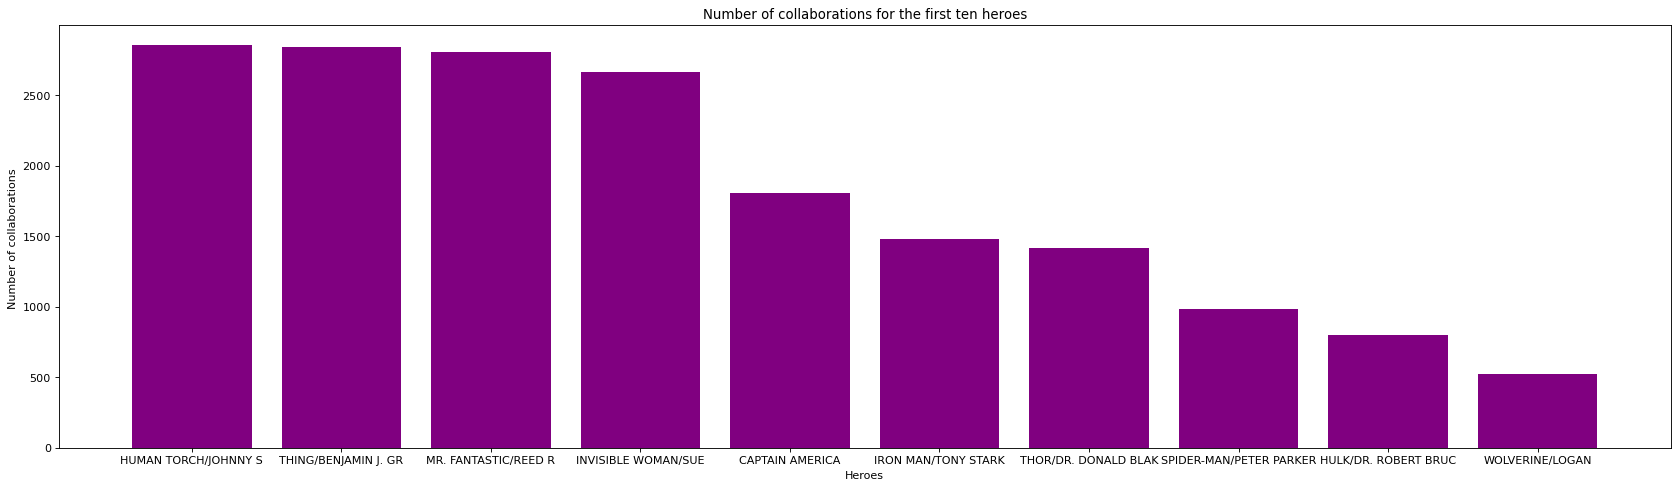

In [37]:
plt.figure(figsize=(26, 7), dpi=80)

# We chose to do the graph only for the first 10 heroes to get a better visualization
sorted_heros = sorted(number_connections(subgraph(G1,10),1).items(), key=lambda x: x[1], reverse = True)

height = [i[1] for i in sorted_heros]
bars = [i[0] for i in sorted_heros]
x_axis = np.arange(len(bars))

plt.bar(x_axis, height, color="purple")

plt.xticks(x_axis, bars)

plt.xlabel('Heroes')
plt.ylabel('Number of collaborations ')
plt.title('Number of collaborations for the first ten heroes')

plt.show()

V4: A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

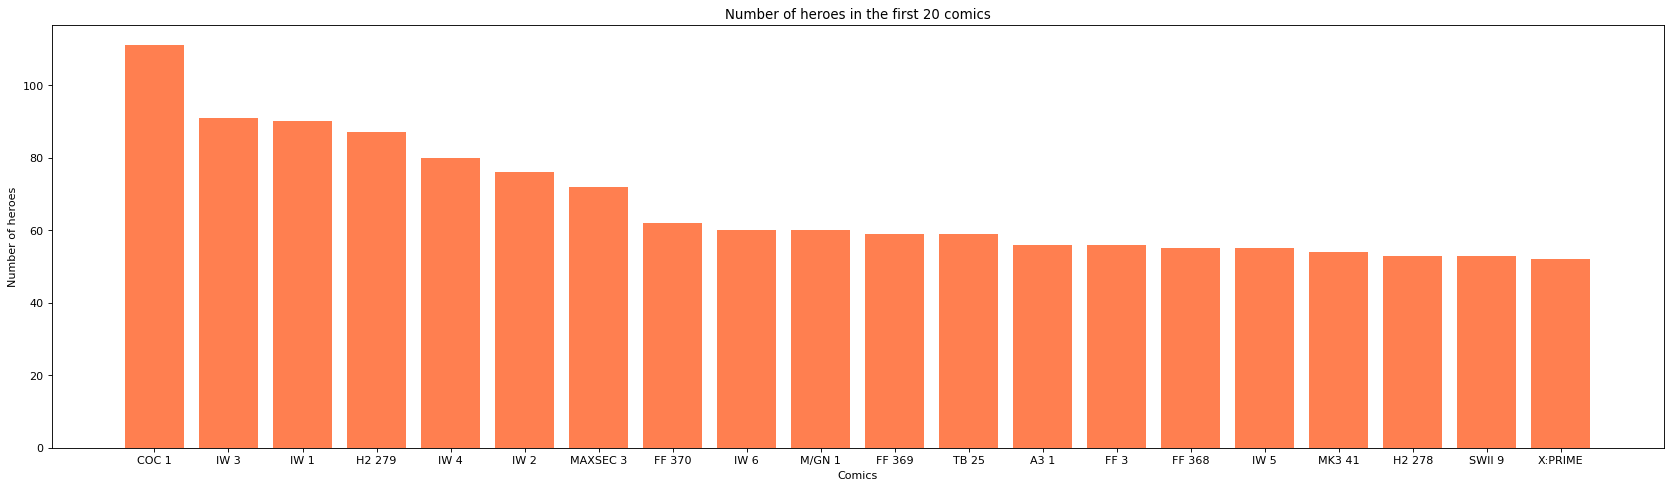

In [38]:

plt.figure(figsize=(26, 7), dpi=80)

# We chose to do the graph only for the first 20 comics to get a better visualization
sorted_comics = sorted(heros_per_comic(G2, 2,20).items(), key=lambda x: x[1], reverse = True)

height = [t[1] for t in sorted_comics]
bars = [t[0] for t in sorted_comics]
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color="coral")

plt.xticks(y_pos, bars)


plt.xlabel('Comics')
plt.ylabel('Number of heroes')
plt.title('Number of heroes in the first 20 comics')

plt.show()

V5: A plot depicting the degree distribution of the network

In [39]:
values = distribution_degree(G2).values()

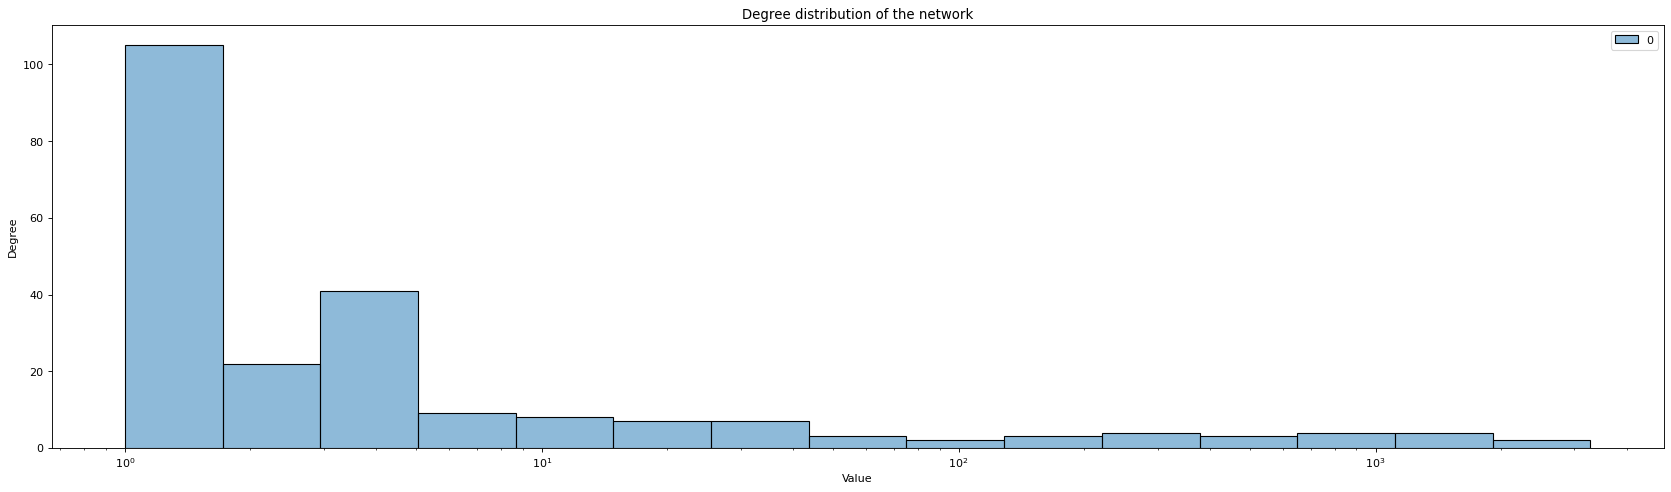

In [40]:
plt.figure(figsize=(26, 7), dpi=80)
# Plot the density graph
# We use the log_scale to get a better visualization
sns.histplot(values,log_scale=True)
plt.xlabel('Value')
plt.ylabel('Degree')
plt.title('Degree distribution of the network')
plt.show()

### Functionality 2 - Find top superheroes!

Input:
- The graph data
- A node (hero or comic)
- One of the given metrics : Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality
- N: denoting the top N heroes that their data should be considered

Output:
- The metric's value over the considered graph
- The given node's value

We start by explain the four metrics:

- Betweenness centrality: This metric measures how many times a node acts as a bridge along the shortest path between two other nodes. A node with high betweenness centrality has a large influence on the communication between other nodes in the graph. If a node has a high betweenness centrality, it means that it is likely to be a bottleneck or a gatekeeper in the communication between other nodes, as information needs to pass through it.

- PageRank: This is a measure of the importance of a node in a graph. It was developed by Google to rank web pages in their search engine. In a graph, a node with a high PageRank value is considered to be important. This can be because it has many connections to other nodes, or because it is connected to nodes that are themselves important.

- Closeness centrality: This metric measures how close a node is to all other nodes in the graph. A node with high closeness centrality has a short average distance to all other nodes. This means that it is well-connected and can reach other nodes quickly.

- Degree centrality: This measures the number of connections a node has to other nodes. A node with a high degree centrality has many connections and is well-connected in the graph.

Now, let's consider the scenario where a node has a high betweenness centrality but a low PageRank value. This could mean that the node is important in terms of acting as a bridge between other nodes, but it is not necessarily a "central" node in terms of the overall structure of the graph. On the other hand, if a node has a low betweenness centrality but a high PageRank value, it could mean that it is not a key connector between other nodes, but it is still considered an important node in the graph due to its connections to other important nodes.

In [41]:
# FUNCTIONALITY 2 --> Find top superheroes!

def find_top_superheroes(graph, node, metric, N):

    # check if the node is in the graph 
    if node in graph.nodes():
        
        # check the N in input is valid
        if N>0: 
            
            # make the subgraph
            graph_new=subgraph(graph,N) 
            heroes=top_N_heroes(edges,N)               

            # calculate the metric's value + the respective value of the node
            if metric == "Betweeness":
                # calculate betweenness centrality
                metric_value = nx.betweenness_centrality(graph_new)
            elif metric == "PageRank":
                # calculate PageRank
                metric_value = nx.pagerank(graph_new)
            elif metric == "ClosenessCentrality":
                # calculate closeness centrality
                metric_value = nx.closeness_centrality(graph_new)
            elif metric == "DegreeCentrality":
                # calculate degree centrality
                metric_value = nx.degree_centrality(graph_new)
            else:
                raise ValueError("Invalid metric")
            
            # sort the metric values in descending order
            #sorted_metric = sorted(metric_value.items(), key=lambda x: x[1], reverse=True)

            mean_centrality = np.array(list(metric_value.values())).mean()

            if graph==G1:
                return metric_value,metric_value[node],mean_centrality
            else:
                for n in graph_new.nodes():
                    if n in heroes:
                        print(n,metric_value[n])

                return metric_value[node],mean_centrality
            
                
        else: 
            raise ValueError("N must be a positive integer")

    else: 
        raise ValueError ("The node you choose is not in the considered graph ")
    

In [ ]:
# Since this output is too long, as a matter of order we do not print it below but put the attached output as a txt file (output_funct2_G1) in the github folder.
test_one=find_top_superheroes(G1,'SPIDER-MAN/PETER PARKER',"DegreeCentrality",100)
test_one

In [43]:
test_two=test_two=find_top_superheroes(G2,'SPIDER-MAN/PETER PARKER',"ClosenessCentrality",10)
test_two

CAPTAIN AMERICA 0.3909143705233271
HULK/DR. ROBERT BRUC 0.3672628069111852
HUMAN TORCH/JOHNNY S 0.3695479777954005
INVISIBLE WOMAN/SUE 0.3640406225587405
IRON MAN/TONY STARK 0.3818468326504885
MR. FANTASTIC/REED R 0.3681108342954366
THING/BENJAMIN J. GR 0.3730525278650163
THOR/DR. DONALD BLAK 0.3727311880883529
WOLVERINE/LOGAN 0.36655170327343134
SPIDER-MAN/PETER PARKER 0.40357071480914


(0.40357071480914, 0.2856004038688739)

### Visualization 2  - Visualize centrality measure

A table containing the information related to the requested centrality measure for:

- The average of the requested centrality measure for all of the network's nodes

- The requested centrality measure's value for the given node

In [44]:
metric_value,metric_value_node,mean_centrality=find_top_superheroes(G1, 'SPIDER-MAN/PETER PARKER',"ClosenessCentrality",1000)

In [45]:
dataframe = pd.DataFrame([{'mean_centrality' : mean_centrality, "metric_value_node" :metric_value_node}])
dataframe.set_index(['mean_centrality', "metric_value_node"]) 

,
mean_centrality,metric_value_node
0.526327,0.772549


### FUNCTIONALITY 3 - Shortest ordered Route

Input:

- The graph data
- A sequence of superheroes h = [h_2, ..., h_n-1]
- Initial node h_1 and an end node h_n
- N: denoting the top N heroes that their data should be considered

Output:

- The shortest walk of comics that you need to read to get from hero_1 to hero_n

In [46]:
# function that outputs the shortest walk of comics that you need to read to get from hero_1 to hero_n
# the algorithm should be run only on the second graph G2

def shortest_route(graph, seq_heroes, h_1, h_n, N):
    if N > 0:
        # extract the names of the top N heroes
        names_heroes = top_N_heroes(edges, N=N)
        
        # make the subgraph
        graph_new = subgraph(graph,N) 
            
        # check whether hero_1 and hero_n are in the subgraph/top N heroes
        if (h_1 in graph_new.nodes()) and (h_n in graph_new.nodes()):
            
            # nodes that we have to visit (from start node to end node)
            need_to_visit = [h_1] + seq_heroes + [h_n]
            
            # here, we'll save the shortest walk
            # starting at hero_1
            walk = [h_1]
            
            for i in range(len(need_to_visit)-1):
                shortest_path = nx.shortest_path(graph_new, need_to_visit[i], need_to_visit[i+1])
                
                # if there is a path between the two nodes, add that path to the walk
                if shortest_path:
                    walk = walk + shortest_path[1:]
                else:
                    return "There is no such path"
            
            # filter out only the 'comic' nodes and return them
            comics = []
            for n in walk:
                if list(graph_new.nodes()[n].values()) == [['comic']]:
                    comics.append(n)
                    
            # return the shortest path that passes through the given nodes and the shortest walk of comics
            return walk, comics
            
        else:
            raise ValueError("Either h_1 or h_n, or both are not in the subgraph (not in the top N heroes)")
        
    else:
        raise ValueError("N must be a positive integer")

In [47]:
# names of the top N heroes
heroes_names = top_N_heroes(edges,N=100)

In [48]:
# check if the function is working correctly
sequence = ['STORM/ORORO MUNROE S','THOR/DR. DONALD BLAK']
walk, comics = shortest_route(G2, sequence,'SPIDER-MAN/PETER PARKER','HAWK', 100)

In [49]:
walk

['SPIDER-MAN/PETER PARKER',
 'A3 10',
 'STORM/ORORO MUNROE S',
 'A 10',
 'THOR/DR. DONALD BLAK',
 'A 100',
 'HAWK']

In [50]:
comics

['A3 10', 'A 10', 'A 100']

### VISUALIZATION 3 - Visualize the shortest-ordered route

- Print the comics in the shortest walk in order

- Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

For the visualization, we will work only with the top 10 heroes.

In [51]:
# names of the top N heroes
hn = top_N_heroes(edges,N=10)

In [52]:
h_seq = ['IRON MAN/TONY STARK','INVISIBLE WOMAN/SUE']
short_walk, walk_comics = shortest_route(G2, h_seq,'SPIDER-MAN/PETER PARKER','THOR/DR. DONALD BLAK', 10)

In [53]:
short_walk

['SPIDER-MAN/PETER PARKER',
 'A 118',
 'IRON MAN/TONY STARK',
 'A 127',
 'INVISIBLE WOMAN/SUE',
 'A 127',
 'THOR/DR. DONALD BLAK']

In [54]:
print("Comics in the shortest walk: ", walk_comics)

Comics in the shortest walk:  ['A 118', 'A 127', 'A 127']


In [55]:
# save the edges of the shortest path in a new variable
walk_edges = []

for i in range(len(short_walk)-1):
    walk_edges.append((short_walk[i],short_walk[i+1]))

walk_edges

[('SPIDER-MAN/PETER PARKER', 'A 118'),
 ('A 118', 'IRON MAN/TONY STARK'),
 ('IRON MAN/TONY STARK', 'A 127'),
 ('A 127', 'INVISIBLE WOMAN/SUE'),
 ('INVISIBLE WOMAN/SUE', 'A 127'),
 ('A 127', 'THOR/DR. DONALD BLAK')]

In [56]:
# create a subgraph of the nodes and edges in the shortest path
G_shortpath = nx.Graph()
G_shortpath.add_nodes_from(short_walk)
G_shortpath.add_edges_from(walk_edges)

In [57]:
nx.info(G_shortpath)

'Graph with 6 nodes and 5 edges'

In [58]:
# Get the positions of the nodes using spring layout (we are using those positions to draw the labels later)
pos = nx.spring_layout(G_shortpath)

In [59]:
# start and end nodes of the walk
start_end_nodes = [short_walk[0],short_walk[-1]]

# set the colors for the nodes
# red for the start and end nodes and green for the rest of the nodes
node_colors = ['red' if n in start_end_nodes else 'green' for n in short_walk]

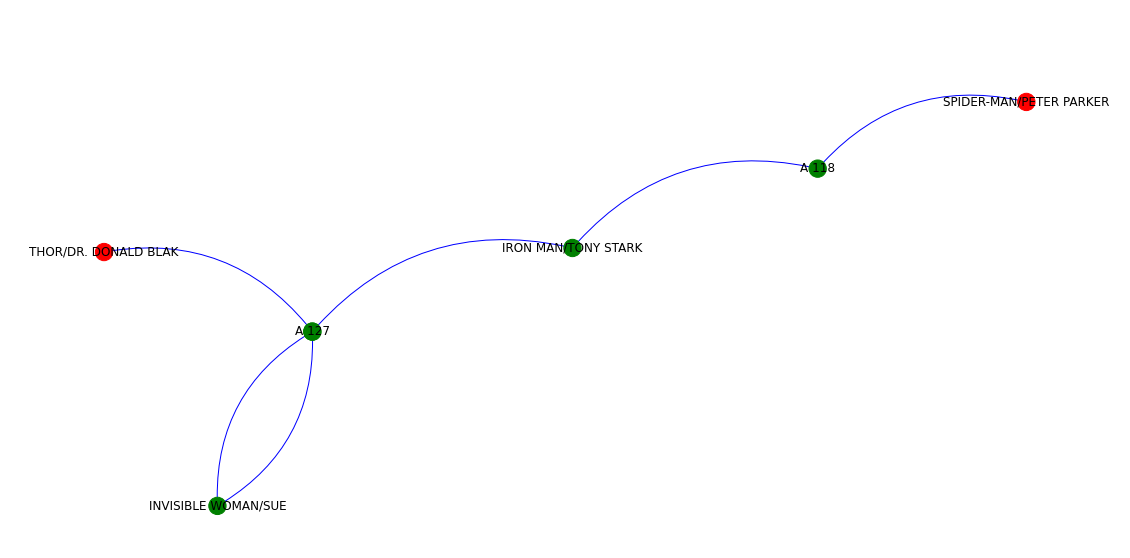

In [61]:
plt.figure(figsize=(20,10))

# draw the nodes that are in the shortest path (both heroes and comics)
nx.draw_networkx_nodes(G_shortpath, pos, nodelist = short_walk, node_color = node_colors)

# add labels/names to the nodes
nx.draw_networkx_labels(G_shortpath,pos)

# draw the edges that are in the shortest path
nx.draw_networkx_edges(G_shortpath, pos, edgelist = walk_edges, edge_color='b', connectionstyle='arc3, rad = 0.3', arrows = True)
# show the plot
ax=plt.gca()
ax.axis('off')
plt.show()


### FUNCTIONALITY 4 - Disconnecting Graphs

Input:

- The graph data
- heroA: a superhero to which will relate sub-graph G_a
- heroB: a superhero to which will relate sub-graph G_b
- N: denoting the top N heroes that their data should be considered

Output:

- The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

In [62]:
def disconnecting_graphs(graph, heroA, heroB, N):
    if N > 0:
        # extract the names of the top N heroes
        names_heroes = top_N_heroes(edges, N=N)

        # create a subgraph from G1 or G2
        graph_new=subgraph(graph,N)
            
        # check whether heroA and heroB are in the subgraph/top N heroes
        if (heroA in graph_new.nodes()) and (heroB in graph_new.nodes()):
            # find the minimum cut; it computes the value and the node partition of a minimum (s, t)-cut.
            min_cut = nx.minimum_cut(graph_new, heroA, heroB, capacity='weight')
            
            # the two subgraphs G_a and G_b
            G_a = min_cut[1][0]
            G_b = min_cut[1][1]
            
            # calculate the number of edges in the min cut (#edges that connect the two subgraphs in the original graph)
            min_num_links = 0
            for i in G_a:
                for j in G_b:
                    if j in graph_new[str(i)]:
                        min_num_links += 1
            return min_num_links
            
        else:
            raise ValueError("Either one or both heroes are not in the subgraph (not in the top N heroes)")
        
    else:
        raise ValueError("N must be a positive integer")

In [63]:
disconnecting_graphs(G1, 'SPIDER-MAN/PETER PARKER', 'HUMAN TORCH/JOHNNY S', 100)

97

### VISUALIZATION 4 - Visualize the disconnected graph

- Print the number of the links that should be disconnected
- Plot the original graph
- Plot the graph after removing the links and identify the two nodes

In [64]:
# 1) Number of link that should be disconnected
def links(graph,hero1,hero2,N):
    min_num_links=disconnecting_graphs(graph,hero1,hero2,N)
    return (f"The minum number of links that should be disconnected are {min_num_links}.")

In [65]:
links(G1, 'SPIDER-MAN/PETER PARKER', 'HUMAN TORCH/JOHNNY S', 10)

'The minum number of links that should be disconnected are 9.'

In [66]:
g=subgraph(G1,10)

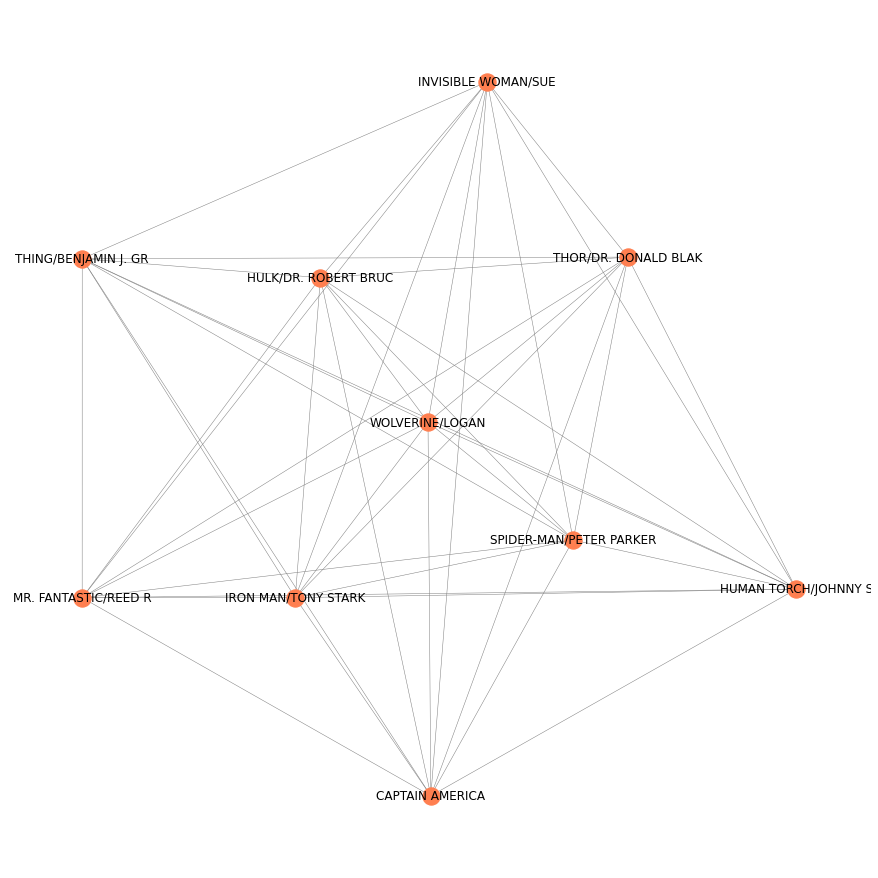

In [67]:
# 2) Plot the orginal graph

fig=plt.figure(figsize=(12,12))
nx.draw(g, with_labels=True, node_color="coral",edge_color="gray",width=0.5)

# show the plot
plt.show()


In [68]:
# 3) Plot the graph after removing the links
 
def V4 (graph, heroA, heroB,N):
    # Check if there is a path between heroA and heroB in the original graph
    G=subgraph(graph,N)
    if not nx.has_path(G, heroA, heroB):
        return G
    
    # Create a copy of the original graph
    G_copy = G.copy()
    
    # Iterate until there is no path between heroA and heroB
    while nx.has_path(G_copy, heroA, heroB):
        # Find all shortest paths between heroA and heroB
        shortpath = list(nx.all_shortest_paths(G_copy, heroA, heroB))

        remove_edges = []
            
        for i in shortpath:
            if len(i) == 2:
                # If there is only one edge between heroA and heroB, remove it
                G_copy.remove_edge(heroA, heroB)
            else:
                # Find the middle node and the one next to it
                middle = len(i)//2
                app = i[middle], i[middle+1]
                remove_edges.append(app)
        # Remove the edges from the graph
        G_copy.remove_edges_from(set(remove_edges))
        
    return G_copy

In [69]:
mod_graph=V4(G1, 'SPIDER-MAN/PETER PARKER', 'HUMAN TORCH/JOHNNY S',10)

In [70]:
# Plot the modified graph
node_colors = ['violet' if n in ['SPIDER-MAN/PETER PARKER', 'HUMAN TORCH/JOHNNY S'] else 'skyblue' for n in list(mod_graph.nodes())]
node_sizes = [300 if n in ['SPIDER-MAN/PETER PARKER', 'HUMAN TORCH/JOHNNY S'] else 100 for n in list(mod_graph.nodes())]

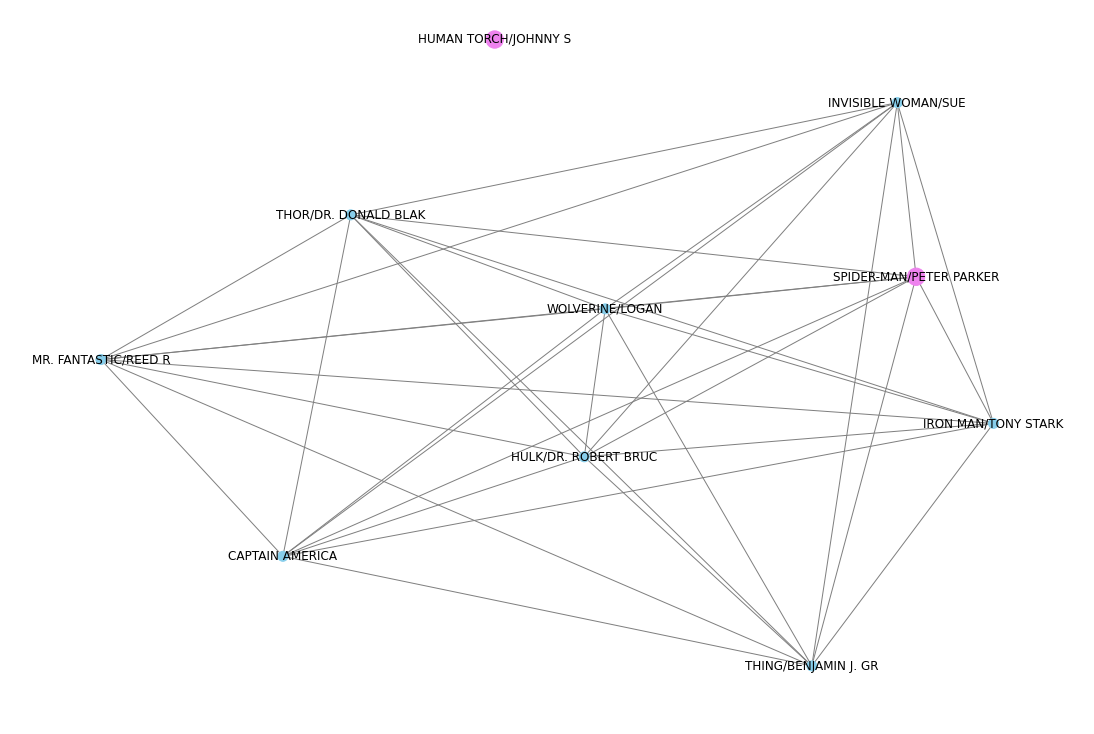

In [72]:
plt.figure(figsize=(15,10))
pos = nx.spring_layout(g)
nx.draw(mod_graph, with_labels=True, pos = pos, node_size = node_sizes, node_color = node_colors, edge_color="gray")

### FUNCTIONALITY 5 - Extracting Communities

Input:

- The graph data
- N: denoting the top N heroes that their data should be considered
- Hero_1: denoting the name of one of the heroes
- Hero_2: denoting the name of one of the heroes

Output:

- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of heroes that belong to them.
- If the Hero_1 and Hero_2 belongs to the same community

We need to use the Girvan-Newman Algorithm for Community Detection.

This algorithm is based on the edge betweenness centrality value.

The edge betweenness centrality value is the number of shortest paths that pass through an edge in a network. 

STEP 1: THE MINIMUN NUMBER OF EDGES THAT SHOULD BE REMOVED

In [73]:
# Create a subgraph 

g=subgraph(G1,20)

In [74]:
# Girvan_Newman algorithm 

def girvan_newman(graph):
    def edge_to_remove(graph):
        scores = nx.edge_betweenness_centrality(graph)
        return max(scores, key=scores.get)

    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)
    counter = 0
    while sg_count == 1:
        edge = edge_to_remove(graph)  # call edge_to_remove() function
        graph.remove_edge(*edge)
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)
        counter += 1
    return counter

In [75]:
girvan_newman(g)

19

STEP 2: A LIST OF COMMUNITIES, EACH CONTAINS A LIST OF HEROES THAT BELONG TO THEM

In [76]:
def list_communities(graph):
    node_groups = []
    visited = set()
    for node in graph.nodes():
        if node not in visited:
            community = set(nx.node_connected_component(graph, node))
            node_groups.append(list(community))
            visited.update(community)
    return node_groups

In [77]:
list_communities(g)

[['IRON MAN/TONY STARK'],
 ['HULK/DR. ROBERT BRUC',
  'CAPTAIN AMERICA',
  'VISION',
  'INVISIBLE WOMAN/SUE',
  'SPIDER-MAN/PETER PARKER',
  'THING/BENJAMIN J. GR',
  'WASP/JANET VAN DYNE',
  'JAMESON, J. JONAH',
  'SCARLET WITCH/WANDA',
  'CYCLOPS/SCOTT SUMMER',
  'THOR/DR. DONALD BLAK',
  'MR. FANTASTIC/REED R',
  'WOLVERINE/LOGAN',
  'DAREDEVIL/MATT MURDO',
  'HAWK',
  'HUMAN TORCH/JOHNNY S',
  'BEAST/HENRY &HANK& P',
  'WATSON-PARKER, MARY',
  'DR. STRANGE/STEPHEN']]

STEP 3: IF HERO_1 AND HERO_2 BELOGNS TO THE SAME COMMUNITY

In [78]:
def heroes_same_communities(graph, hero1, hero2):
    for community in nx.connected_components(graph):
        if hero1 in community and hero2 in community:
            return f'The hero {hero1} is in the same communities of the hero {hero2}'
    return f'The hero {hero1} is NOT in the same communities of the hero {hero2}'

In [79]:
heroes_same_communities(g, 'CANNONBALL II/SAM GU','SPIDER-MAN/PETER PARKER')

'The hero CANNONBALL II/SAM GU is NOT in the same communities of the hero SPIDER-MAN/PETER PARKER'

In [81]:
heroes_same_communities(g, 'HUMAN TORCH/JOHNNY S','BEAST/HENRY &HANK& P')

'The hero HUMAN TORCH/JOHNNY S is in the same communities of the hero BEAST/HENRY &HANK& P'

STEP 4: PUT EVERYTHING IN A SINGLE FUNCTION

In [82]:
# FUNCTIONALITY 5

def extracting_communities(graph,N,hero1,hero2):
    if graph==G1:
        g=subgraph(graph,N)

        # the minimum number of edges that should be removed to form communities
        min_num_edges=girvan_newman(g)

        # A list of communities, each containing a list of heroes that belong to them
        list_comm=list_communities(g)

        # hero_1 and hero_2 belong to the same community
        same_comm=heroes_same_communities(g,hero1,hero2)

        return min_num_edges,list_comm,same_comm
    
    else:
        raise ValueError("The graph you chose is not valid")       

In [83]:
extracting_communities(G1,20,'PUNISHER II/FRANK CA','SHANG-CHI')

(19,
 [['IRON MAN/TONY STARK'],
  ['HULK/DR. ROBERT BRUC',
   'CAPTAIN AMERICA',
   'VISION',
   'INVISIBLE WOMAN/SUE',
   'SPIDER-MAN/PETER PARKER',
   'THING/BENJAMIN J. GR',
   'WASP/JANET VAN DYNE',
   'JAMESON, J. JONAH',
   'SCARLET WITCH/WANDA',
   'CYCLOPS/SCOTT SUMMER',
   'THOR/DR. DONALD BLAK',
   'MR. FANTASTIC/REED R',
   'WOLVERINE/LOGAN',
   'DAREDEVIL/MATT MURDO',
   'HAWK',
   'HUMAN TORCH/JOHNNY S',
   'BEAST/HENRY &HANK& P',
   'WATSON-PARKER, MARY',
   'DR. STRANGE/STEPHEN']],
 'The hero PUNISHER II/FRANK CA is NOT in the same communities of the hero SHANG-CHI')

### VISUALIZATION 5 -Visualize the communities

- Print the number of links that should be removed to have the communities
- A table depicting the communities and the heroes that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Hero_1 and Hero_2

In [84]:
min_num_edges, list_comm, same_comm = extracting_communities(G1,20, 'CAPITAN AMERICA' ,'IRON MAN/TONY STARK' )

In [85]:
# 1) Number of links to remove
print(f'Number of links to remove: {min_num_edges}')

Number of links to remove: 19


In [86]:
# 2) Table depicting communities and the heroes that belong to each community
community_data = []
for i, community in enumerate(list_comm):
    for hero in community:
        community_data.append({'Community': i+1, 'Heroes': hero})

df = pd.DataFrame(community_data)
df.head()

,Community,Heroes
0,1,IRON MAN/TONY STARK
1,2,HULK/DR. ROBERT BRUC
2,2,CAPTAIN AMERICA
3,2,VISION
4,2,INVISIBLE WOMAN/SUE


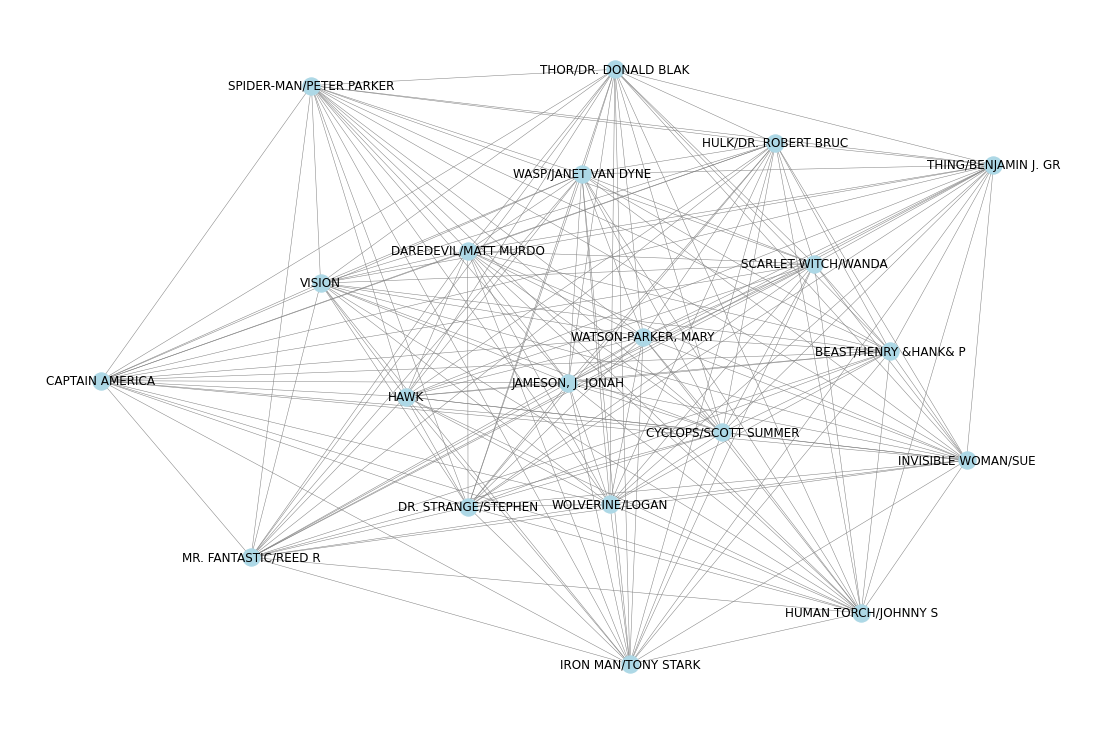

In [88]:
# 3) Plot of the original graph
g1= subgraph(G1,20)
fig=plt.figure(figsize=(15,10))
nx.draw(g1, with_labels=True, node_color="lightblue",edge_color="gray",width=0.5)

plt.show()

Now we have to plot the graph showing the different communities

In [89]:
# Assign he communities as the attribute of the subgraph

# Initialize the node_communities dictionary
node_communities = {}

# Iterate through the rows of the data frame
for index, row in df.iterrows():
    node_name = row['Heroes']  # Assume the node name is in a column called 'node_name'
    community = row['Community']  # Assume the community value is in a column called 'community'
    
    # Add the node and its community value to the dictionary
    node_communities[node_name] = community

In [90]:
node_communities = {key: 0 if value == 1 else 1 for key, value in node_communities.items()}

In [91]:
nx.set_node_attributes(g, node_communities, 'community')

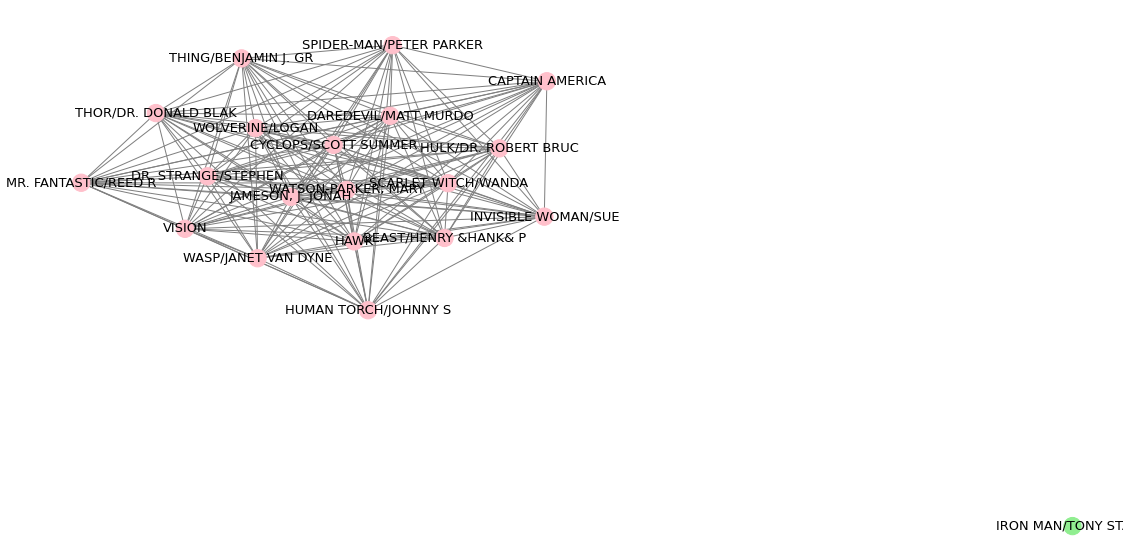

In [94]:
# 4) Plot the graph showing the communities

fig=plt.figure(figsize=(20,10))
pos = nx.spring_layout(g)
labels={node:node for node in g.nodes()}

# create a list of color maps, one for each community
cmap = ['lightgreen', 'pink']

# draw the nodes of the graph
nx.draw_networkx_nodes(g, pos, node_color=[cmap[g.nodes[node]['community']] for node in g])

# draw the edges of the graph
nx.draw_networkx_edges(g, pos, edge_color='gray')

nx.draw_networkx_labels(g,pos,labels, font_size=13)

# show the plot
ax=plt.gca()
ax.axis('off')
plt.show()

# 6) ALGORITHMIC QUESTION

Since in the exercise the input is a single string that shows the direction of the segment lines and contains only the characters R, L, U, and D, without two equal consecutive characters, we first want to create a function which returns a list with all the possible steps given the general directions in input (i.e. input='R', output=['R', 'RR']). We want a repetition of the same direction maximum equal to 2, since the grid of the mobile phone has dimension 3x3.

In [95]:
from itertools import combinations

def generate_double_letter_strings(string):
    double_letter_strings = []
    # We enerate all combinations of double letters of the same character
    for char in string:
        new_string = string.replace(char, char * 2)
        if new_string not in double_letter_strings:
            double_letter_strings.append(new_string)
    # We generate all combinations of double letters of different characters
    if len(set(string)) > 1:
        for char_pair in combinations(set(string), 2):
            new_string = string
            for char in char_pair:
                new_string = new_string.replace(char, char * 2)
            if new_string not in double_letter_strings:
                double_letter_strings.append(new_string)
    # We add the original string if it is not already present
    if string not in double_letter_strings:
        double_letter_strings.append(string)
    # In the end, we add a string with every letter present twice
    if len(string)>=3:
        w=''
        for i in string:
            w += i*2
        double_letter_strings.append(w)

    return double_letter_strings

Then, we proceed creating the main function, which returns the number of possible patterns, considering the directions in input as a one-step direction.

In [96]:
def count_patterns(directions):
    count = 0
    # Starting positions in the grid
    start = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]    
    # Iterate through the directions in the input string
    for i in range(len(start)):
        # Initialize a set to keep track of visited positions
        visited = []
        x=start[i][0]
        y=start[i][1]
        visited.append((x,y))
        for direction in directions:
            # Update the current position based on the direction
            if direction == "R":
                x += 1
            elif direction == "L":
                x -= 1
            elif direction == "U":
                y += 1
            elif direction == "D":
                y -= 1
            # If the current position is not a valid position or has been visited before, stop processing this direction
            if x < 0 or x > 2 or y < 0 or y > 2 or (x, y) in visited:
                break
            # Otherwise, add the current position to the set of visited positions
            visited.append((x, y))
            # If every direction was valid, we increment our counter
            if len(visited) == (len(directions)+1):
                count += 1
                    
    return count

To conclude, therefore, we create a third function that takes as input the directions in the way the exercise requires, using the generate_double_letter_strings function puts in a list all possible combinations with one and two steps in the same direction, and, with a for loop, we iterate the list and pass each element of it to the count_patterns function, updating a counter that keeps track of the number of patterns for each set of directions.

In [97]:
def tot_count(string):
    # We create a list of possible directions using the function created above
    l=generate_double_letter_strings(string)
    count=0
    # We iterate through the list of directions and pass each element to the function count_patterns
    for i in l:
        count+=count_patterns(i)
    return count

In [98]:
tot_count('R')

9

In [99]:
tot_count('DRU')

15

In [100]:
tot_count('LDRDRUL')

0